# Distributions of token distances
The aim of this notebook is to investigate the evolution of the distances between input token embeddings throughout the different modules and layers of the GPT2 model. The focus lies on the analysis of the distribution of distances to the last token in the input sequence.

##### Library imports:

In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import transformers
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
import DistFuncs as DF # file containing various helper functions

## Calculating token distances for each module
For a short prompt, the module inputs/outputs are extracted via hooks, using the self-implemented functions in DistFuncs.py. The pairwise cosine distances between the token representations in the different stages of the model are calculated and visualised as heatmaps.

In [2]:
# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# define input prompt
prompt = "A pancake (or hotcake, griddlecake, or flapjack) is a flat cake, often thin and round, prepared from a starch-based batter that may contain eggs, milk and butter, and then cooked on a hot surface such as"

# extract module inputs/outputs and names
data, modules =  DF.get_module_data(model, tokenizer, prompt, getInputs=True)

# filter to get the outputs/module names where outputs have the right shape
# the right shape being (# of tokens, Embedding dimension)
data, module_names = DF.filter_by_shape(data, modules, ref_shape=data[1].shape)

# filter out duplicate inputs/outputs that represent the same state
filtered_data, _ = DF.filter_duplicates(data, module_names)

# calculate pairwise token distances
#distances = dist_matr(filtered_outputs, type="euclid") # euclidean distance
distances_cos = DF.dist_matr(np.array(filtered_data), type="cosine") # cosine distance

# create plot labels from tokens 
token_labels = [tokenizer.decode(t) for t in tokenizer.encode(prompt, return_tensors="pt")[0]]

# create module descriptors for plot titles
#decoder_labels = [f"Decoder {n}{x}" for n in range(1, 13) for x in string.ascii_lowercase[:7]] # for shorter labelling 1a, 1b, ..
decoder_points = ["LayerNorm A", "Partial Attention", "Full GPT2Attention", "Att. Residual connection",
                  "LayerNorm B", "GPT2MLP", "MLP Residual connection"]
decoder_labels = [f"Decoder {n} {x}" for n in range(1, 13) for x in decoder_points]
mod_descr = ["Token Embedding", "Positional Embedding", "Full Embedding"] + decoder_labels + ["LayerNorm C"]

# create heatmap plot of pairwise token distances for each module
# here: using a shared linear scale for all plots
# can also be set do individual scales or shared/individual log scale
DF.plot_dist_heatmap(distances_cos, token_labels, mod_descr, scaling='SharedLin', filename="distances_cos")

D:\anaconda3\envs\pytorch_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Creating plot 1/88. Module Token Embedding
Creating plot 2/88. Module Positional Embedding
Creating plot 3/88. Module Full Embedding
Creating plot 4/88. Module Decoder 1 LayerNorm A
Creating plot 5/88. Module Decoder 1 Partial Attention
Creating plot 6/88. Module Decoder 1 Full GPT2Attention
Creating plot 7/88. Module Decoder 1 Att. Residual connection
Creating plot 8/88. Module Decoder 1 LayerNorm B
Creating plot 9/88. Module Decoder 1 GPT2MLP
Creating plot 10/88. Module Decoder 1 MLP Residual connection
Creating plot 11/88. Module Decoder 2 LayerNorm A
Creating plot 12/88. Module Decoder 2 Partial Attention
Creating plot 13/88. Module Decoder 2 Full GPT2Attention
Creating plot 14/88. Module Decoder 2 Att. Residual connection
Creating plot 15/88. Module Decoder 2 LayerNorm B
Creating plot 16/88. Module Decoder 2 GPT2MLP
Creating plot 17/88. Module Decoder 2 MLP Residual connection
Creating plot 18/88. Module Decoder 3 LayerNorm A
Creating plot 19/88. Module Decoder 3 Partial Attention

## Evolution of distances to last token throughout the layer modules
A test prompt of ~750 tokens is used to observe how the distances from each token to the last one in the sequence evolve throughout the different modules that make up the module layers. For each module (except those whose output has a different dimension), the inputs/outputs are extracted, duplicates removed, and the cosine distances between the tokens are calculated. The evolution of the distances to the last token throughout the modules are then visualised.

### Initialise model, extract outputs & calculate distances:

In [3]:
# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# define input prompt
prompt = DF.read_prompt("prompts/prompt_pancake.txt")

# extract module inputs/outputs and names
data, modules =  DF.get_module_data(model, tokenizer, prompt, getInputs=True)

# filter to get the outputs/module names where outputs have the right shape
# the right shape being (# of tokens, Embedding dimension)
data, modules = DF.filter_by_shape(data, modules, ref_shape=data[1].shape)

# filter out duplicate inputs/outputs that represent the same state
filtered_data, filtered_modules = DF.filter_duplicates(data, modules)

# get cosine distances to last token:
dist_from_token, filtered_modules = DF.get_last_token_distance(filtered_data, filtered_modules, ref_shape=filtered_data[1].shape)

# compute mean distance for each module
mean_dist = np.mean(dist_from_token, axis=1)

D:\anaconda3\envs\pytorch_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Plotting the distance evolution:

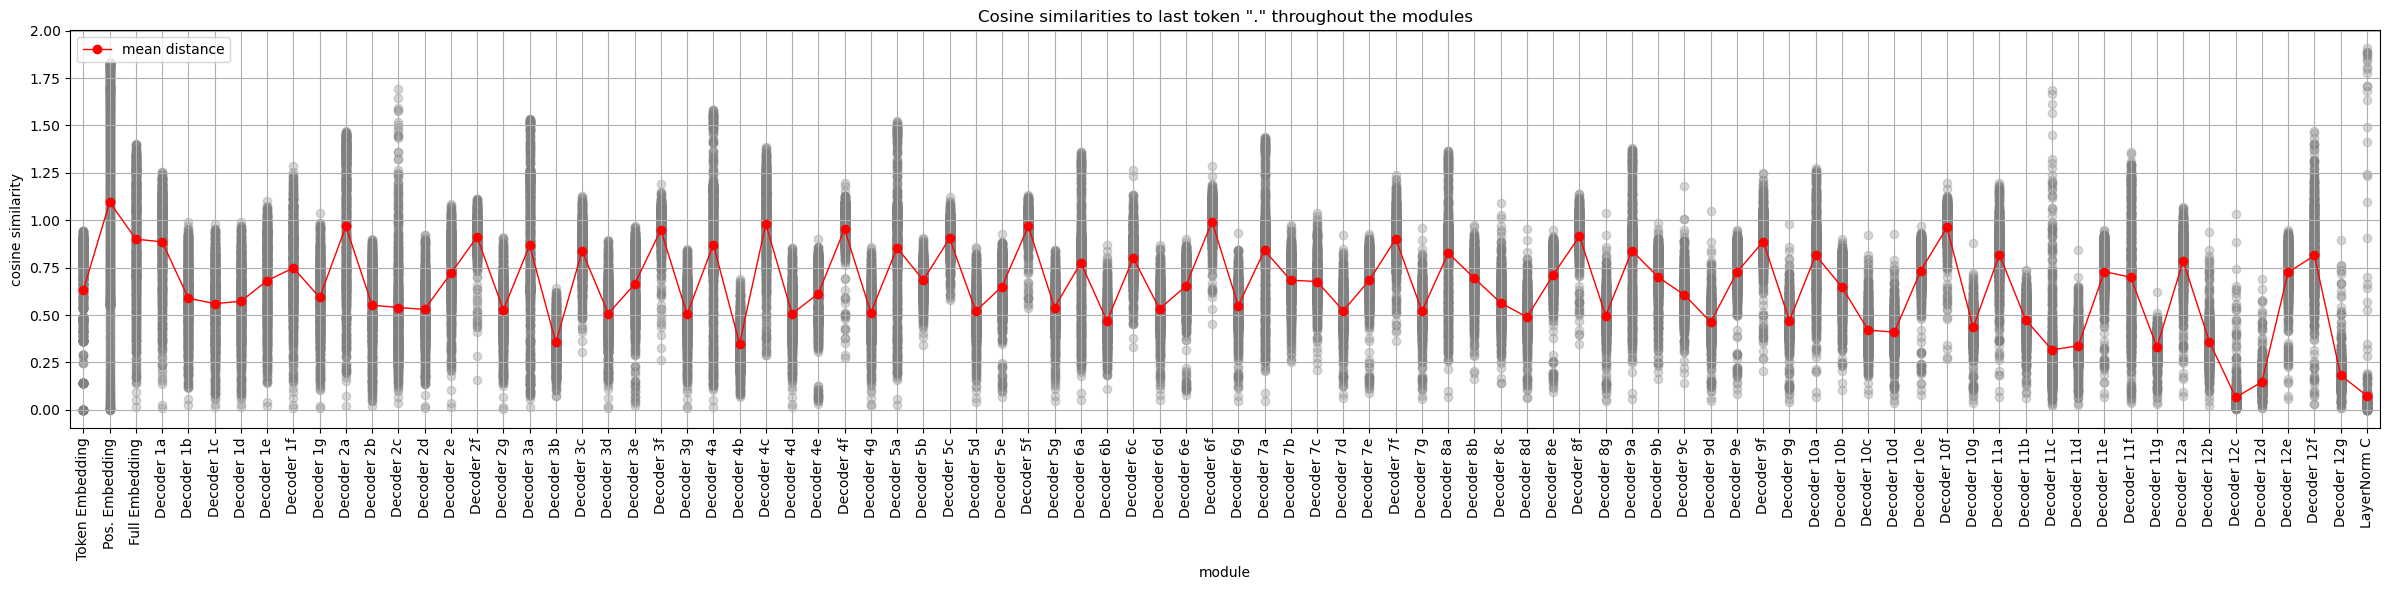

In [4]:
# create module descriptors for plot titles
#decoder_points = ["LayerNorm A", "Partial Attention", "Full GPT2Attention", "Att. Res. connection", "LayerNorm B", "GPT2MLP", "MLP Res. connection"]
#decoder_labels = [f"Decoder {n}{x}" for n in range(1, 13) for x in decoder_points]
decoder_labels = [f"Decoder {n}{x}" for n in range(1, 13) for x in string.ascii_lowercase[:7]] # for shorter labelling 1a, 1b, ..
mod_descr = ["Token Embedding", "Pos. Embedding", "Full Embedding"] + decoder_labels + ["LayerNorm C"]

# get token labels
token_labels = [tokenizer.decode(t) for t in tokenizer.encode(prompt, return_tensors="pt")[0]]
# generate x-axis
x_pos = np.arange(dist_from_token.shape[0])

fig, ax = plt.subplots(figsize=(24, 6))

#for i in token_list:
for i, lab in enumerate(token_labels[:-1]):
    ax.scatter(x_pos, dist_from_token.T[i], lw=1, marker="o", color="grey", alpha=0.3)

ax.plot(x_pos, mean_dist, label="mean distance", lw=1, marker="o", color="red")

ax.set_title(f"Cosine similarities to last token \"{token_labels[-1].strip()}\" throughout the modules")
ax.set_xlabel("module")
ax.set_ylabel("cosine similarity")
ax.set_xticks(x_pos, mod_descr, rotation=90)
ax.set_xlim(min(x_pos)-0.5, max(x_pos)+0.5)
ax.legend(loc="upper left")
ax.grid()
fig.tight_layout()
plt.show()

As boxplot (the blue background indicates the decoder blocks):

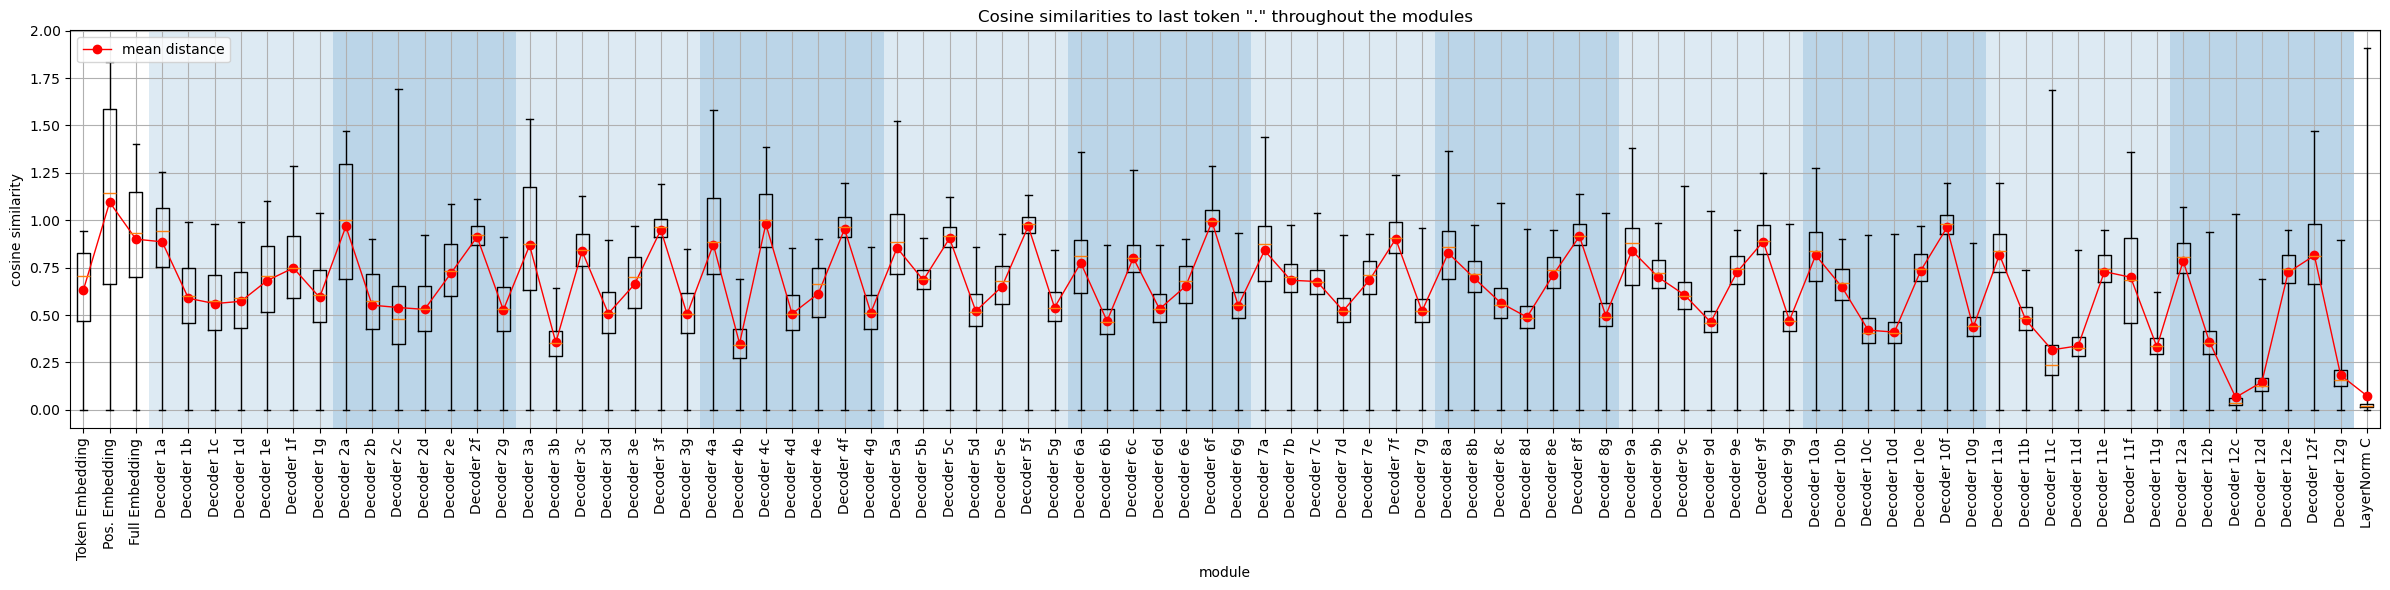

In [5]:
# generate x-axis
x_pos = np.arange(dist_from_token.shape[0])

# create figure
fig, ax = plt.subplots(figsize=(24, 6))

# create boxplot of distance distribution for each module:
ax.boxplot(dist_from_token.T, positions=x_pos, whis=(0, 100))
# plot average distance
ax.plot(x_pos, mean_dist, label="mean distance", lw=1, marker="o", color="red")

# visualize decoder blocks
# might be better to use 2 colors and even/odd instead
cmap = matplotlib.colormaps['Spectral']
for i in range(0, 12):
    if i%2:
        plt.axvspan(i*7+2.5, i*7+9.5, facecolor='tab:blue', alpha=0.3, zorder=-100)
    else: 
        plt.axvspan(i*7+2.5, i*7+9.5, facecolor='tab:blue', alpha=0.15, zorder=-100)

    
ax.set_title(f"Cosine similarities to last token \"{token_labels[-1].strip()}\" throughout the modules")
ax.set_xlabel("module")
ax.set_ylabel("cosine similarity")
ax.set_xticks(x_pos, mod_descr, rotation=90)
ax.set_xlim(min(x_pos)-0.5, max(x_pos)+0.5)

ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

### Distance evolution throughout the decoder blocks:
Furthermore, the distributions of cosine distances of the tokens after each decoder block in the GPT2 module is visualised as boxplot. Each decoder block (`GPT2Block`) is composed of different modules as follows:

```python
GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
(1, 58, 768)
```


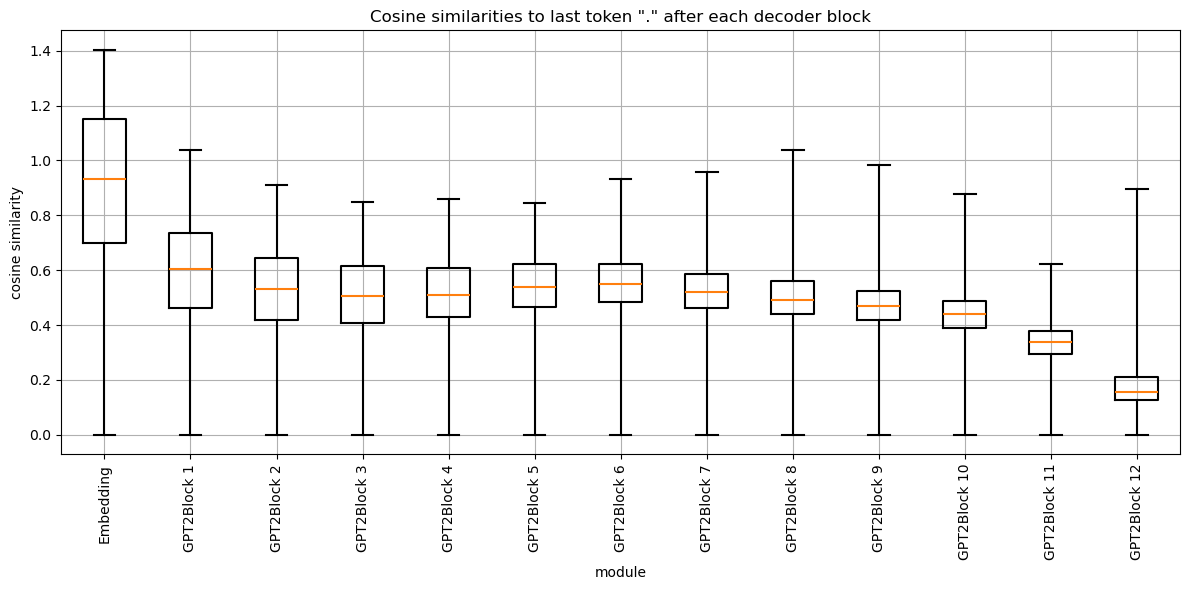

In [6]:
#filter for only the GPT2Block-outputs
gpt2block_mask = filtered_modules == "GPT2Block"
# add position of embedding & first dropout output after embedding
gpt2block_mask[2] = True

dist_from_token_filtered = dist_from_token[gpt2block_mask]

# define x-axis positions
x_pos = np.arange(dist_from_token_filtered.shape[0])

fig, ax = plt.subplots(figsize=(12, 6))

# create boxplot of distance distribution for each module:
ax.boxplot(dist_from_token_filtered.T, positions=x_pos,
           whis=(0, 100), 
           boxprops={"linewidth": 1.5},
           whiskerprops={"linewidth": 1.5}, 
           capprops={"linewidth": 1.5},
           medianprops={"linewidth": 1.5})


ax.set_title(f"Cosine similarities to last token \"{token_labels[-1].strip()}\" after each decoder block")
ax.set_xlabel("module")
ax.set_ylabel("cosine similarity")
ax.set_xticks(x_pos, ["Embedding"]+[f"GPT2Block {i}" for i in range(1, 13)], rotation=90)
ax.set_xlim(min(x_pos)-0.5, max(x_pos)+0.5)
# ax.set_yscale('log')
#ax.legend(loc="upper left")
ax.grid()
fig.tight_layout()
plt.show()

## KDE of token distance distribution
To better understand the distribution of the token distances, a KDE of the distribution of distances to the last token is analysed for each module. This analysis is conducted for 4 different input prompts of ~800 tokens, to allow for comparison.

In [7]:
# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Read prompts
prompt_files = {
    "Dracula": 'prompt_dracula.txt', # 853 tokens
    "Transformers": 'prompt_transformers.txt', # 817 tokens
    "Pancakes": 'prompt_pancake.txt', # 793 tokens
    "Moby Dick": 'prompt_moby_dick.txt' # 811 tokens
}
prompts = {label: DF.read_prompt(file_path) for label, file_path in prompt_files.items()}

# get inputs & outputs, get correctly ordered module names
data = {label: DF.get_module_data(model, tokenizer, prompt, getInputs=True) for label, prompt in prompts.items()}

# filter data
filtered_data = {label: DF.filter_by_shape(d, mods, ref_shape=d[1].shape) for label, (d, mods) in data.items()}
filtered_data = {label: DF.filter_duplicates(d, mods) for label, (d, mods) in filtered_data.items()}

# Calculate distances to respective last token
# Dict contains module idx, module names and distances for each prompt
distances = {label: DF.get_last_token_distance(np.array(d), mods) for label, (d, mods) in filtered_data.items()} 

D:\anaconda3\envs\pytorch_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


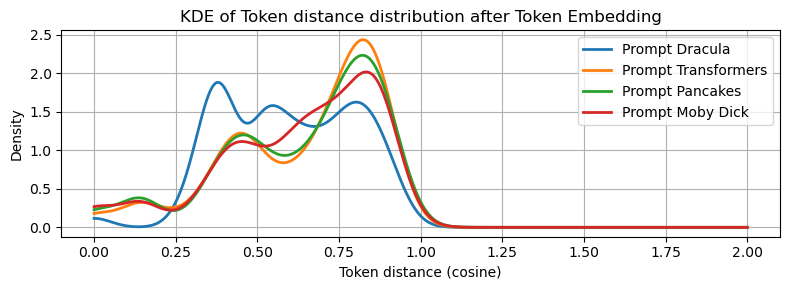

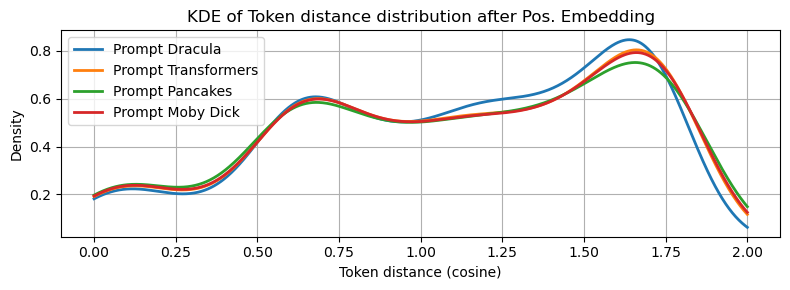

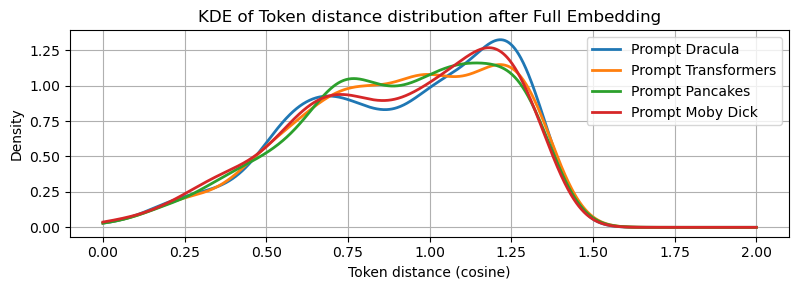

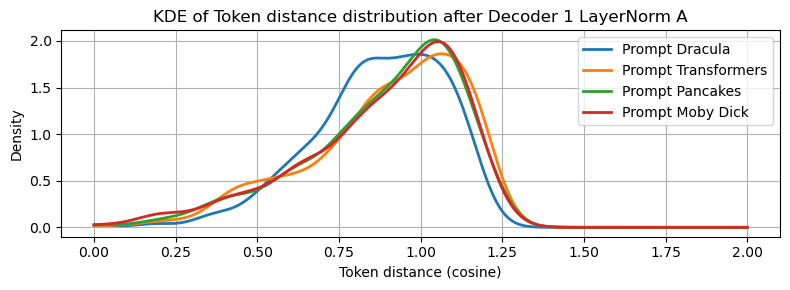

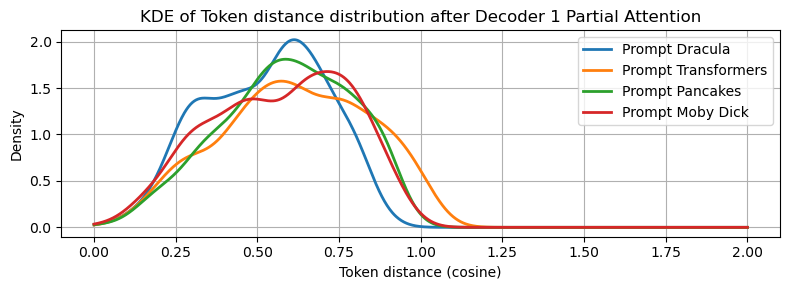

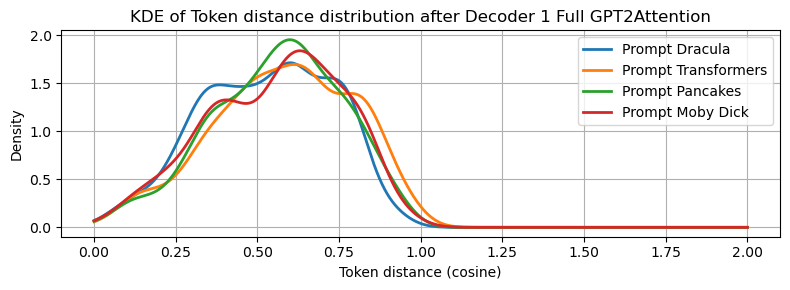

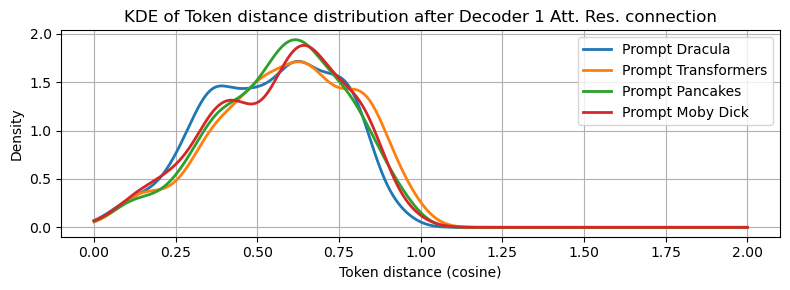

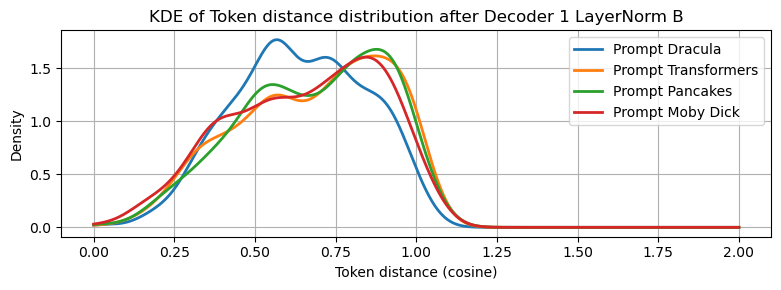

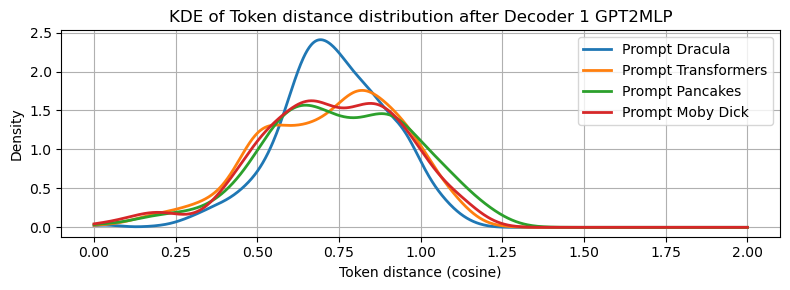

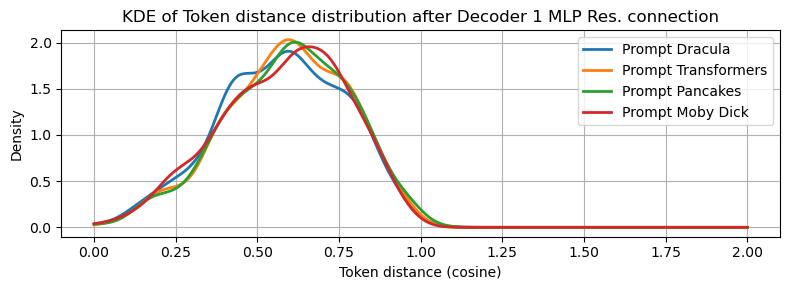

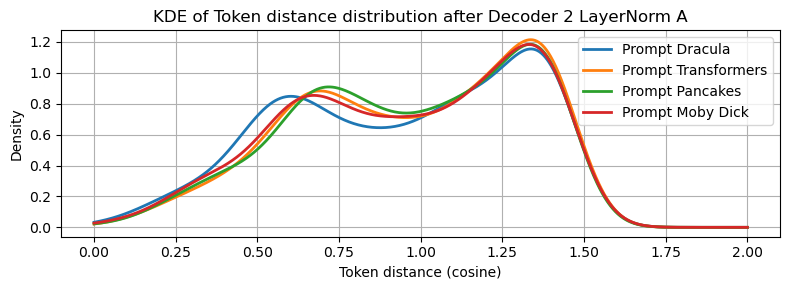

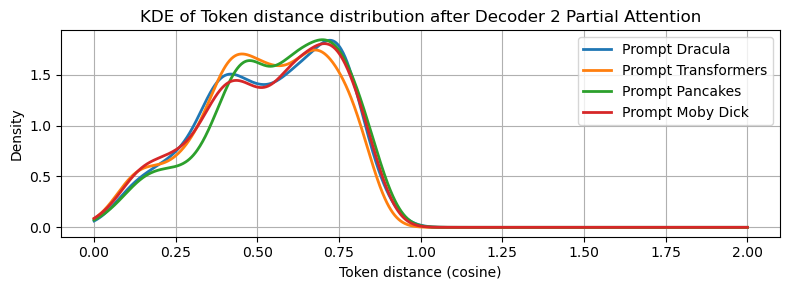

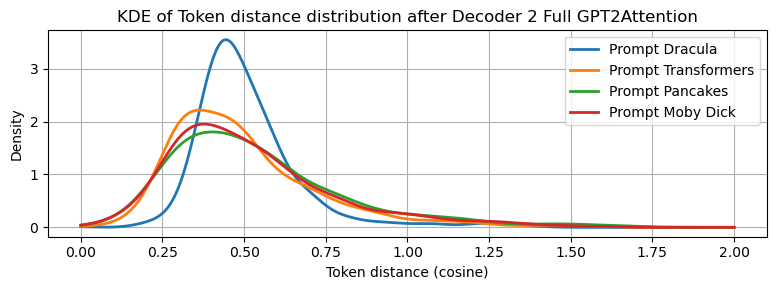

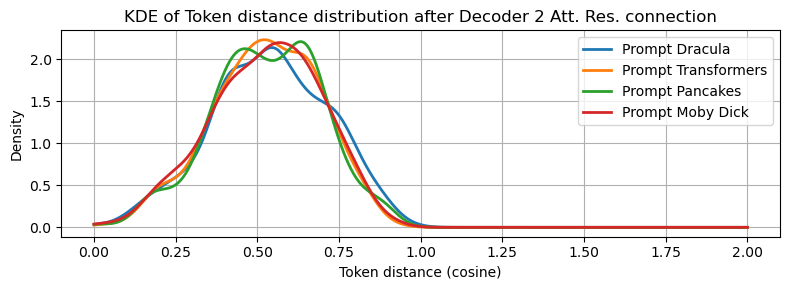

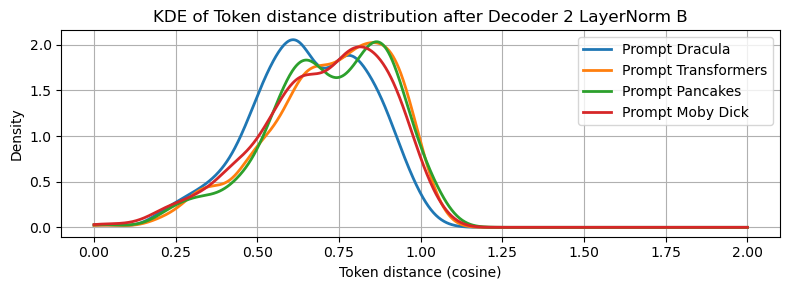

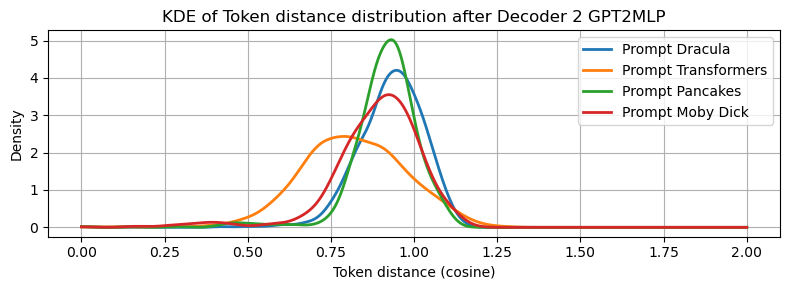

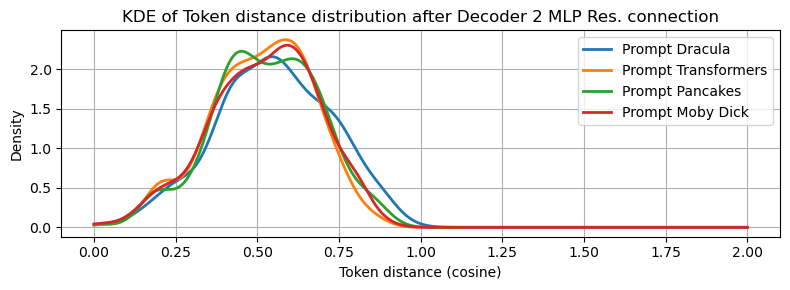

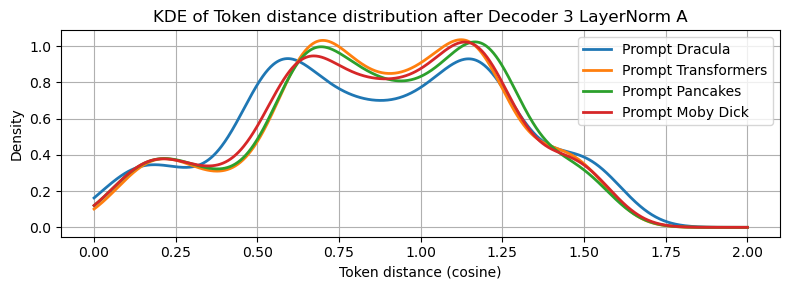

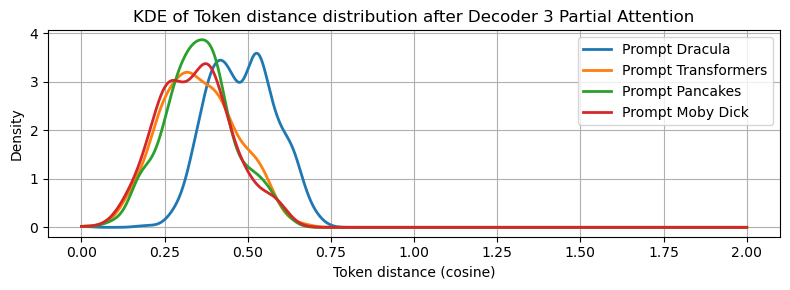

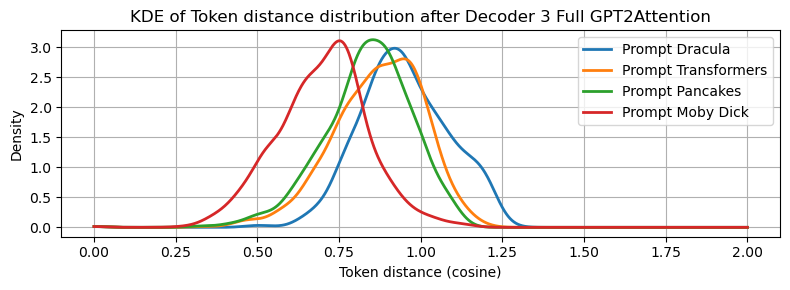

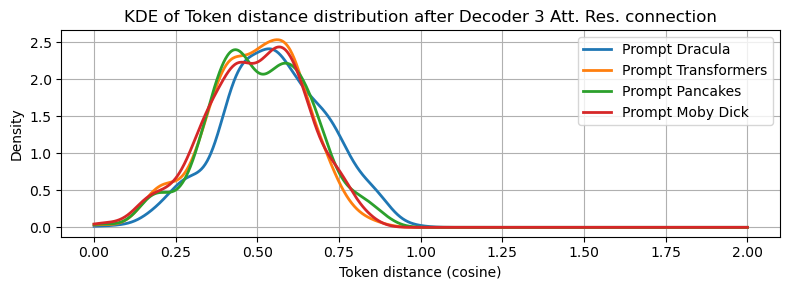

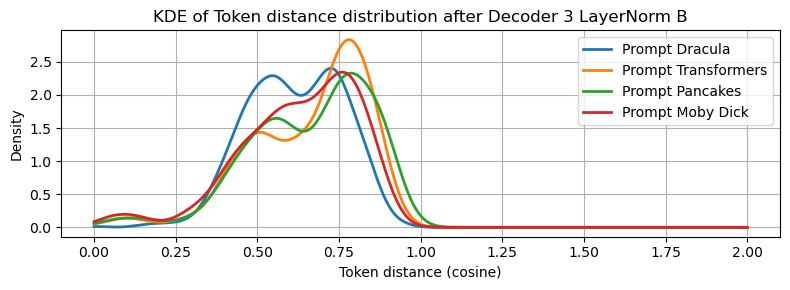

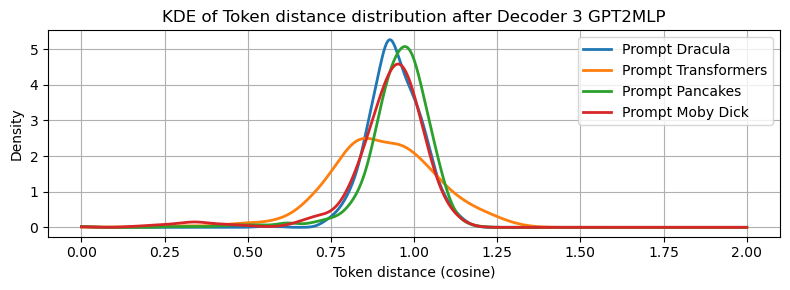

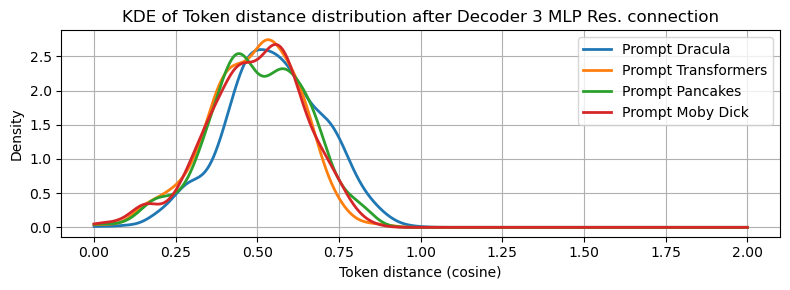

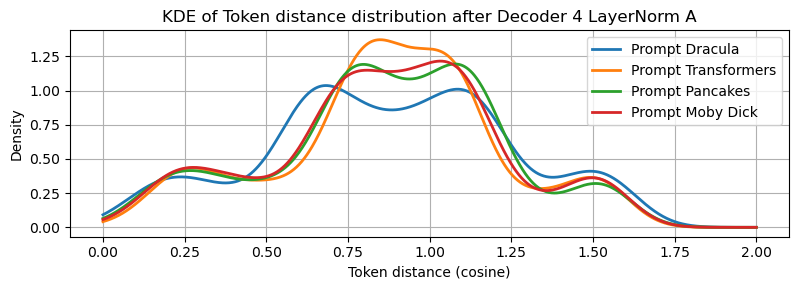

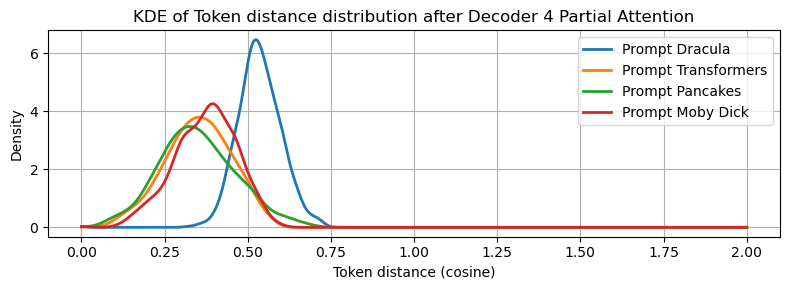

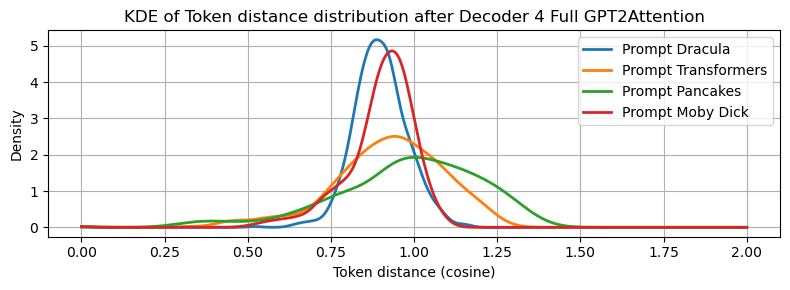

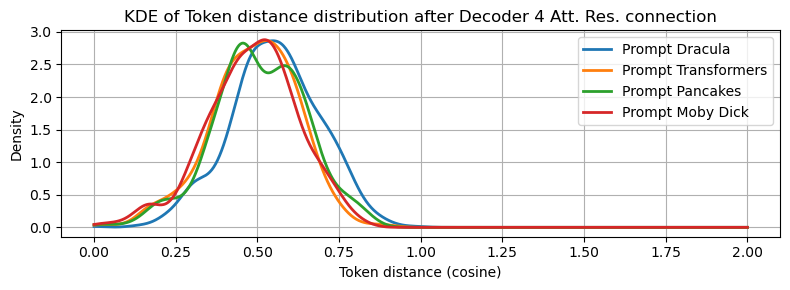

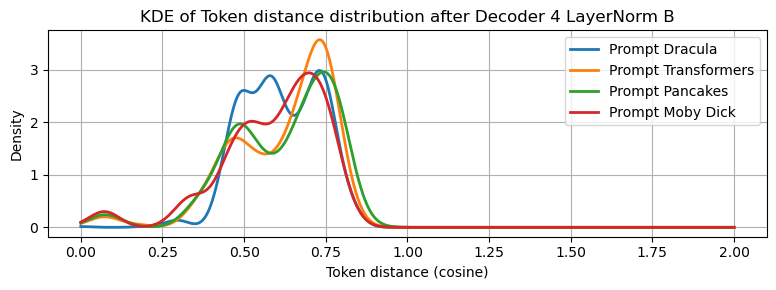

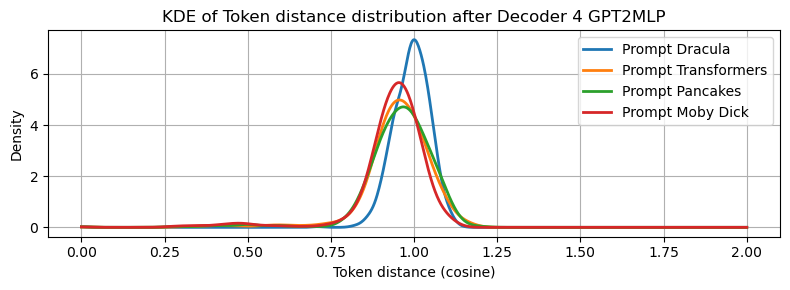

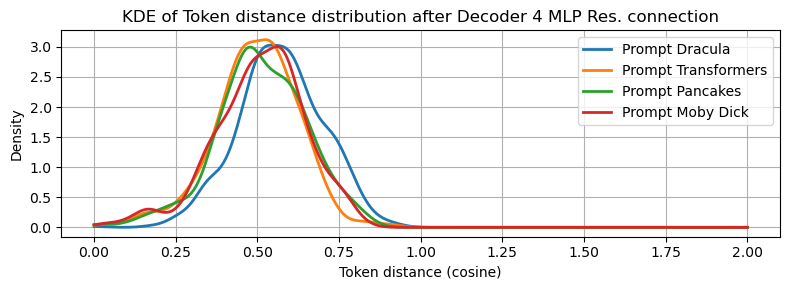

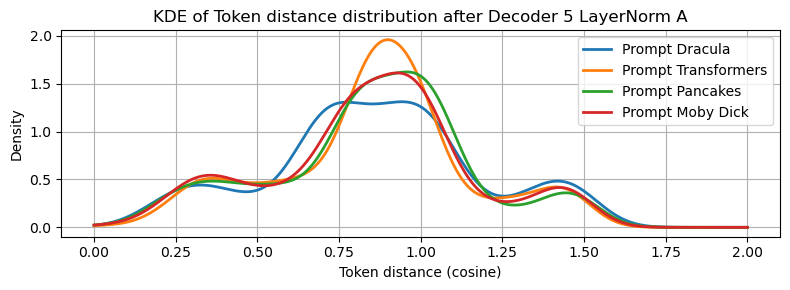

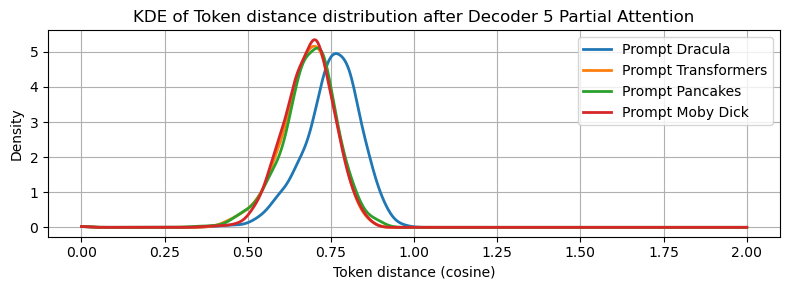

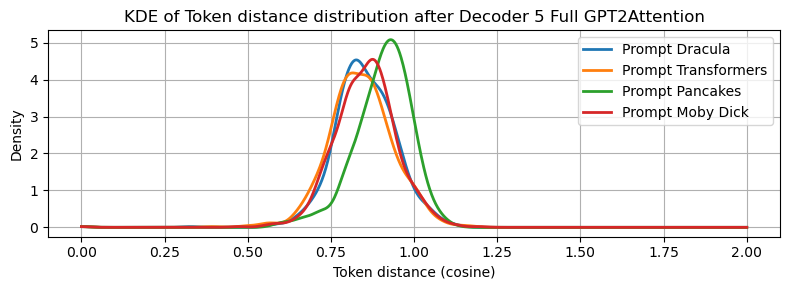

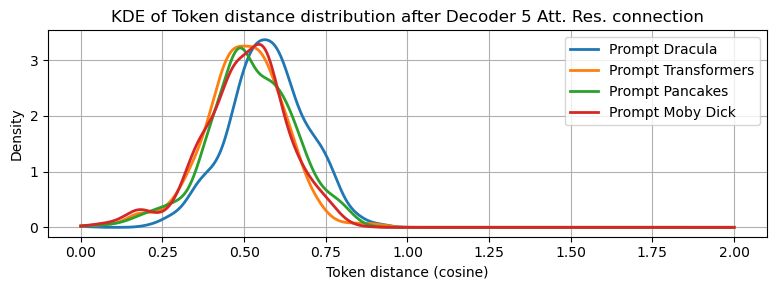

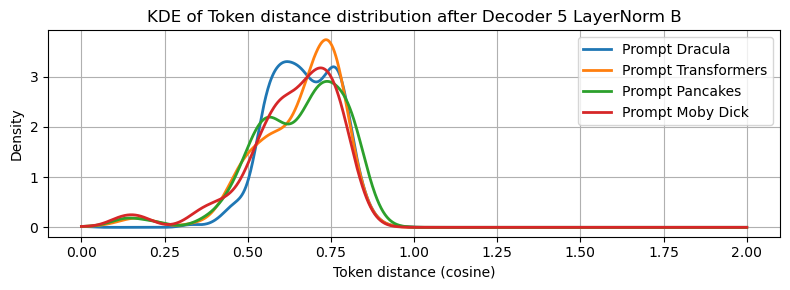

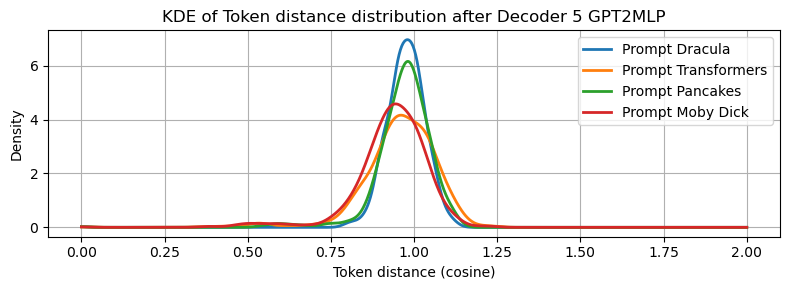

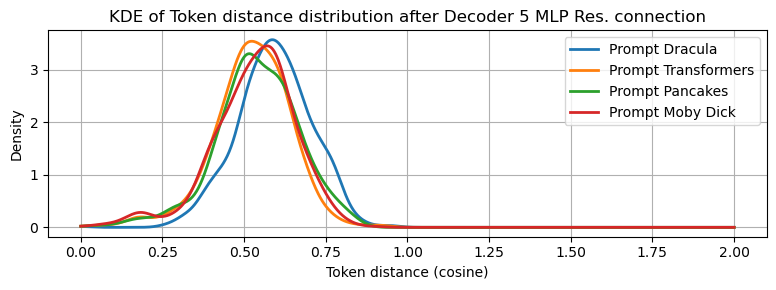

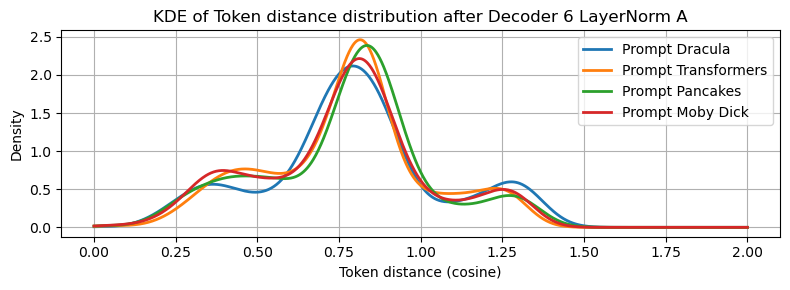

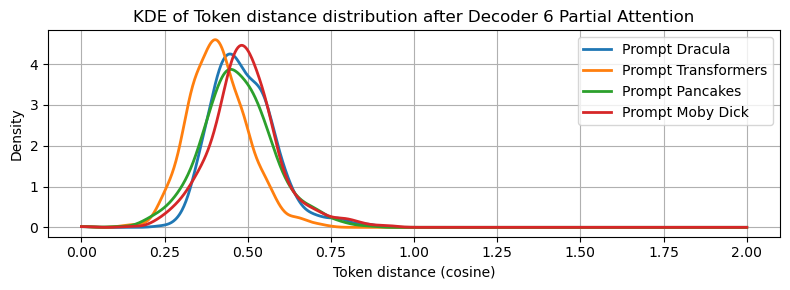

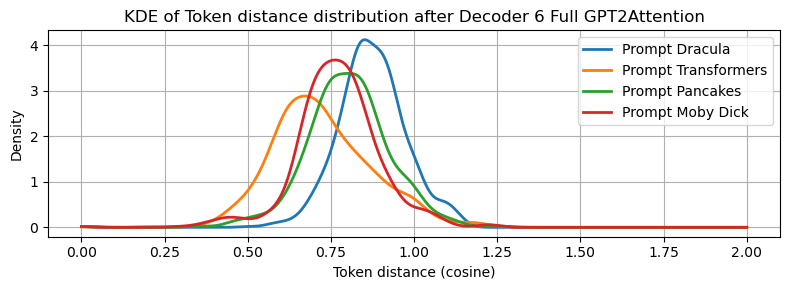

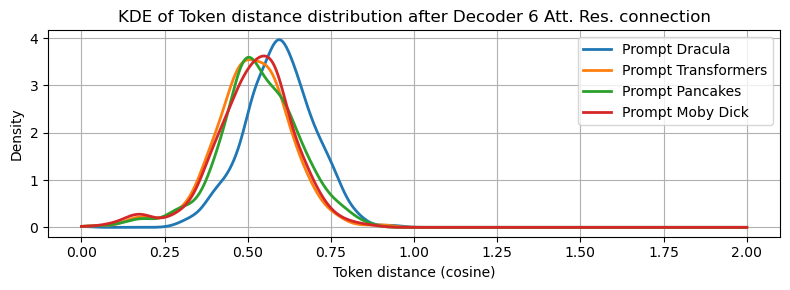

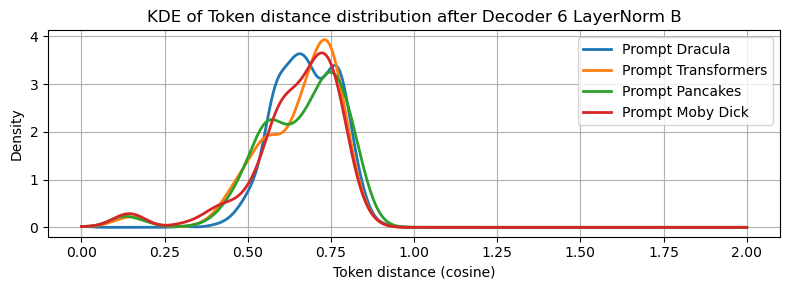

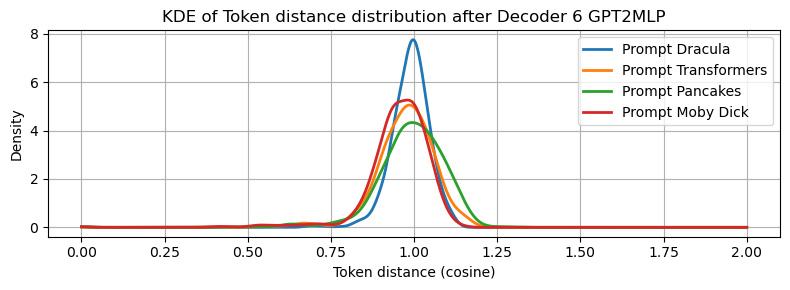

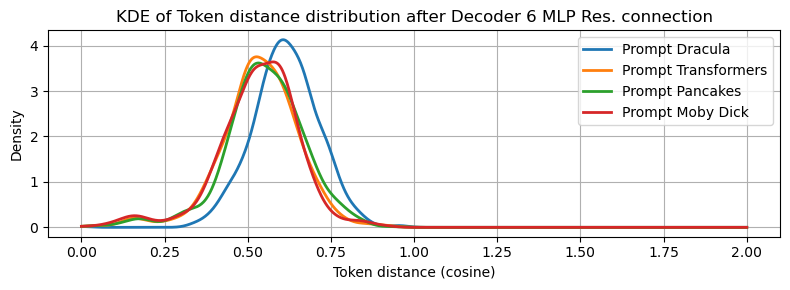

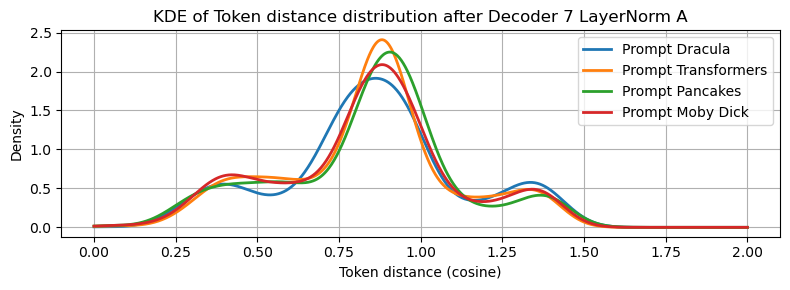

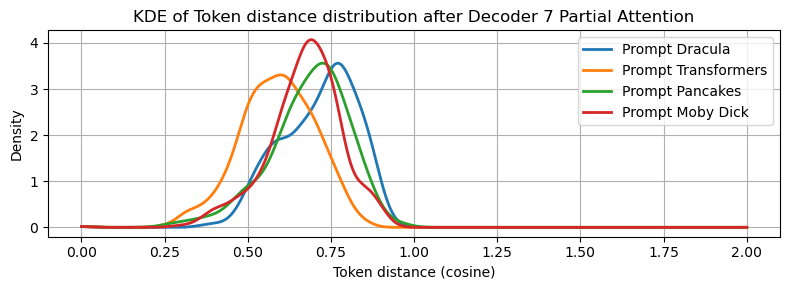

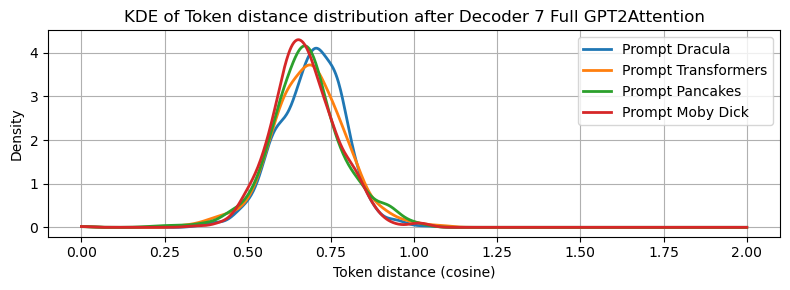

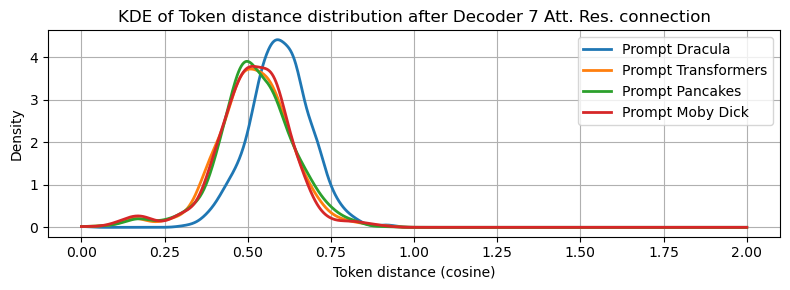

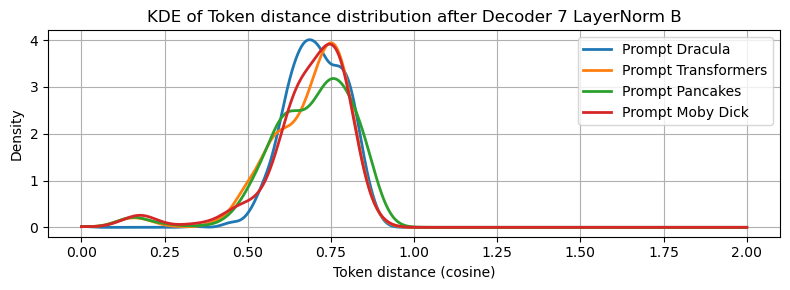

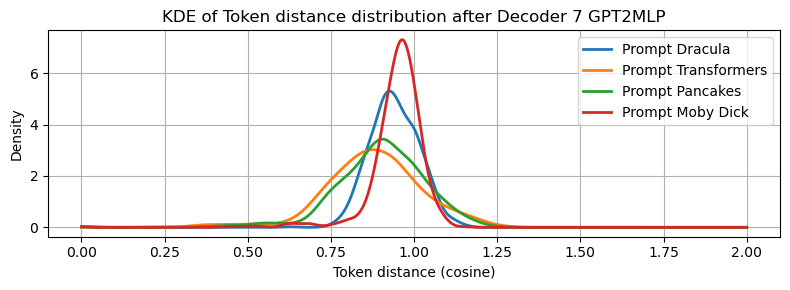

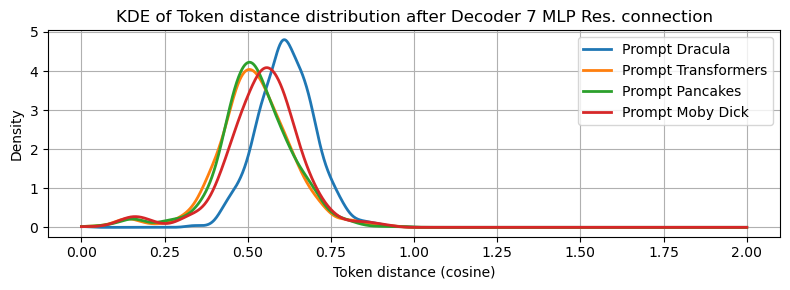

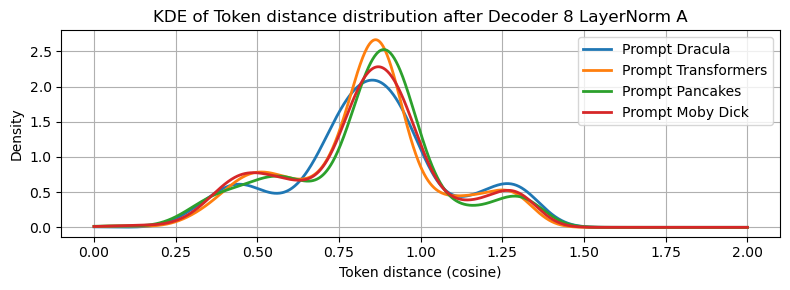

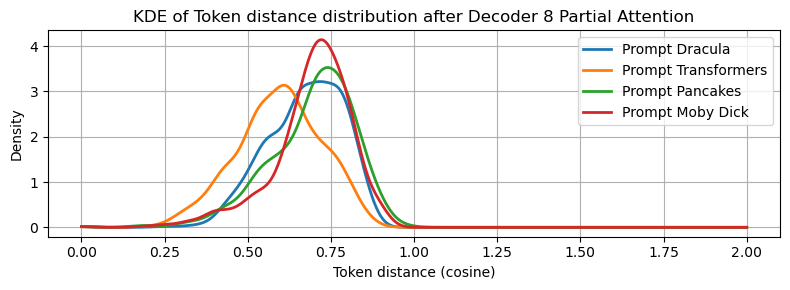

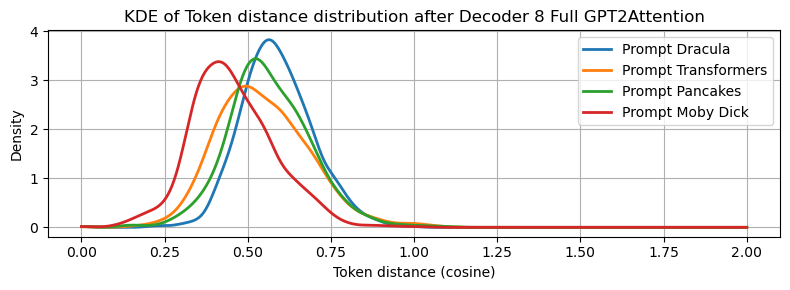

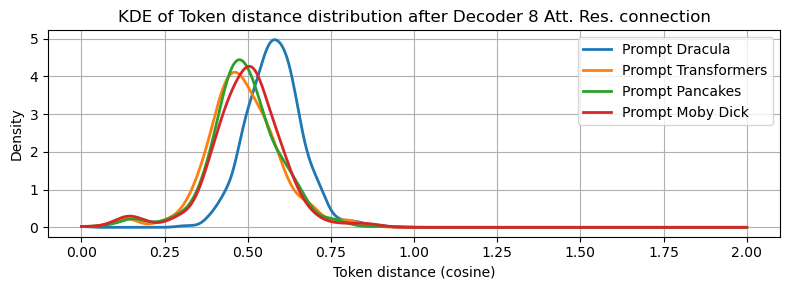

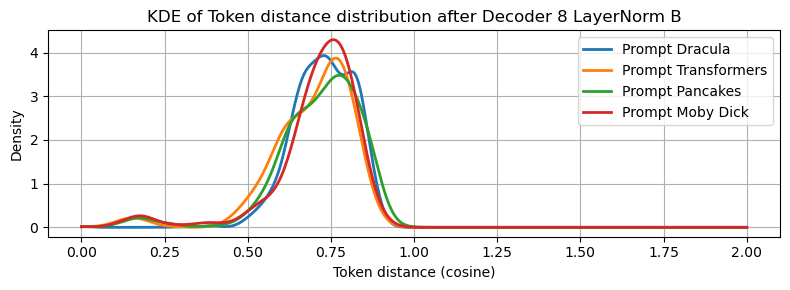

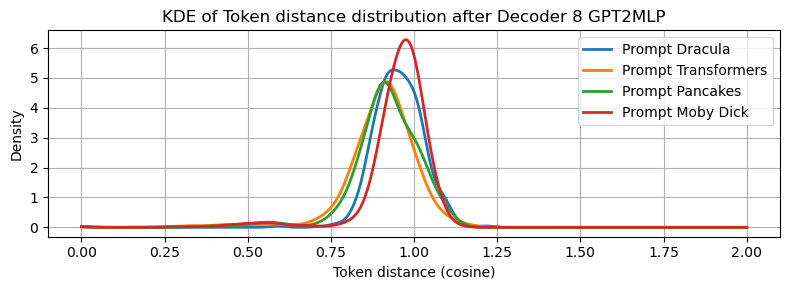

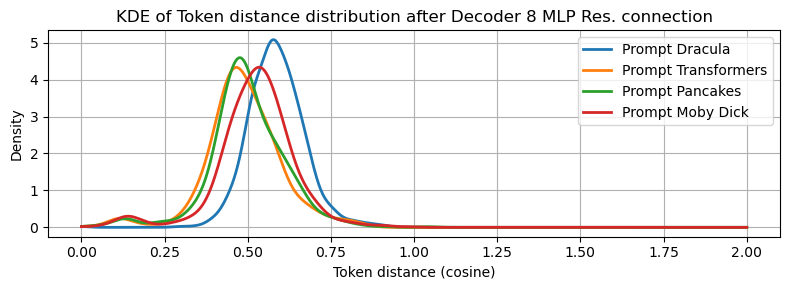

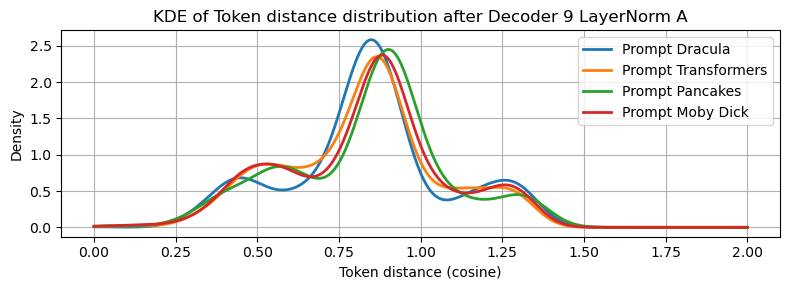

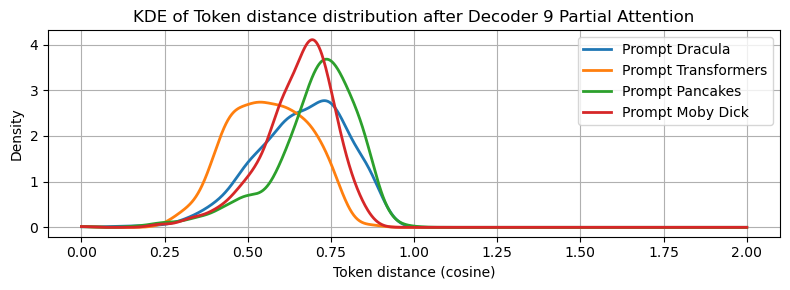

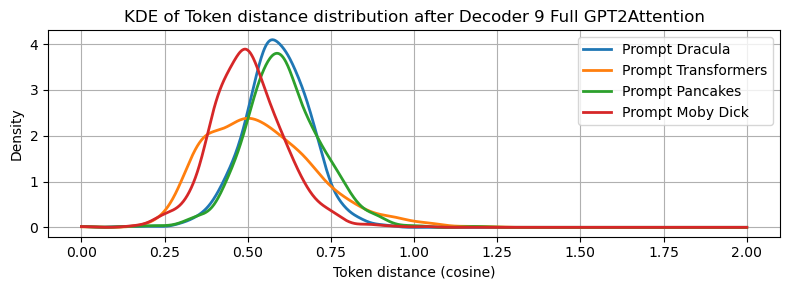

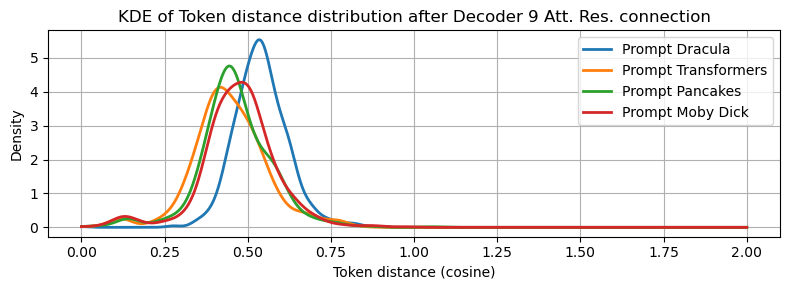

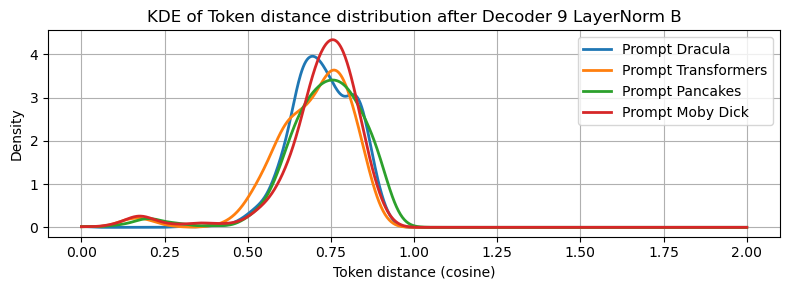

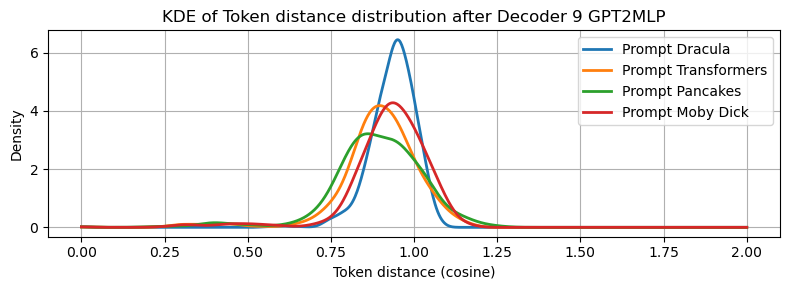

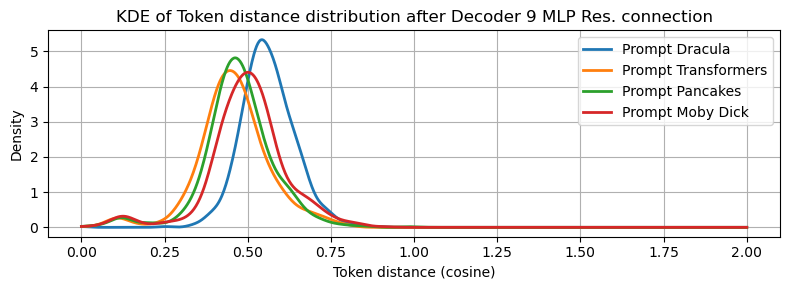

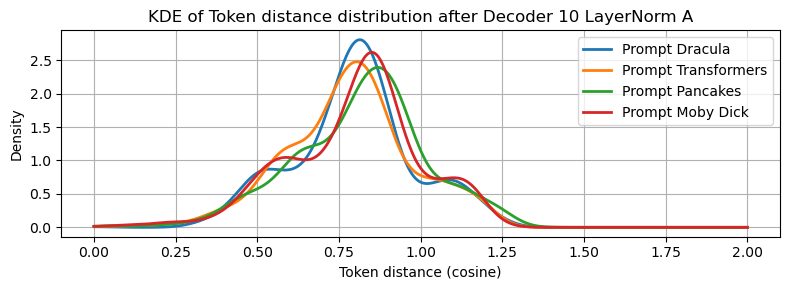

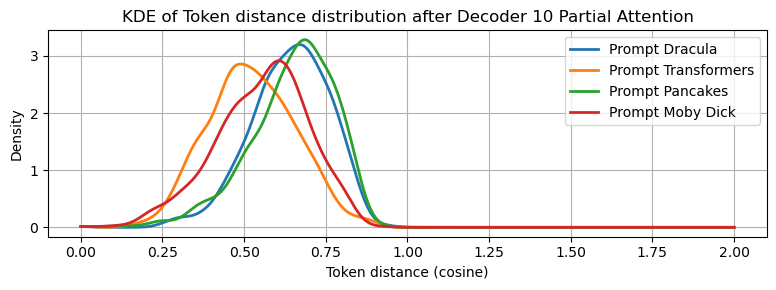

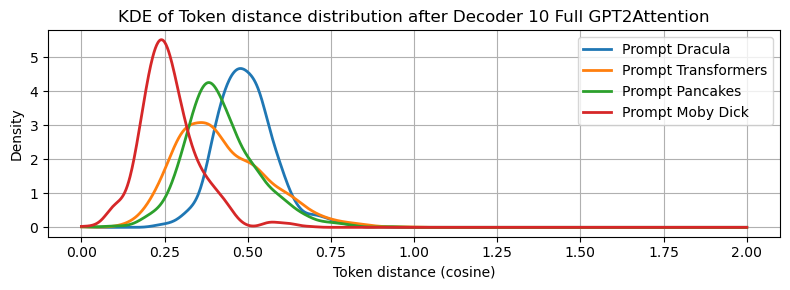

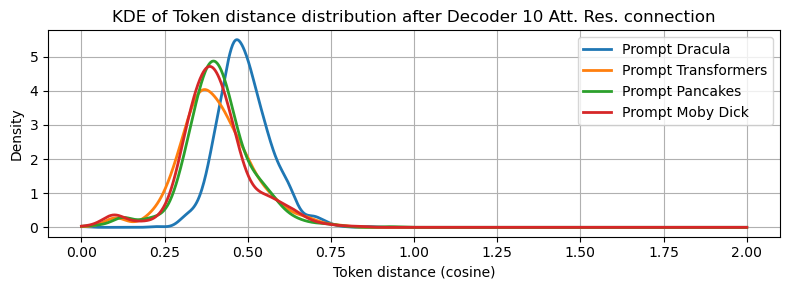

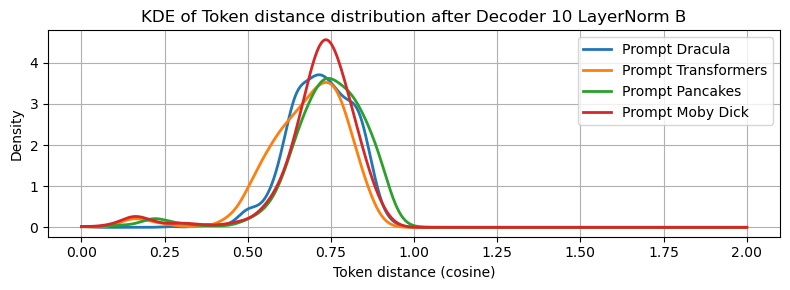

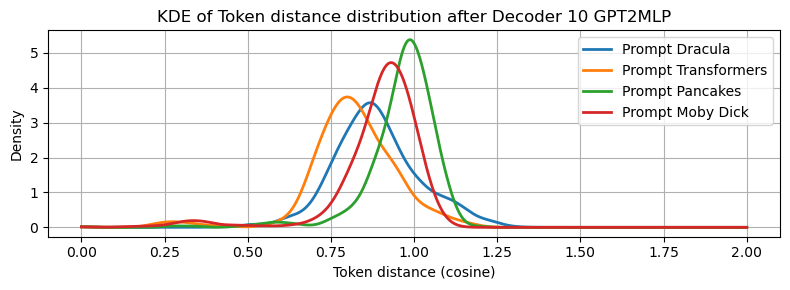

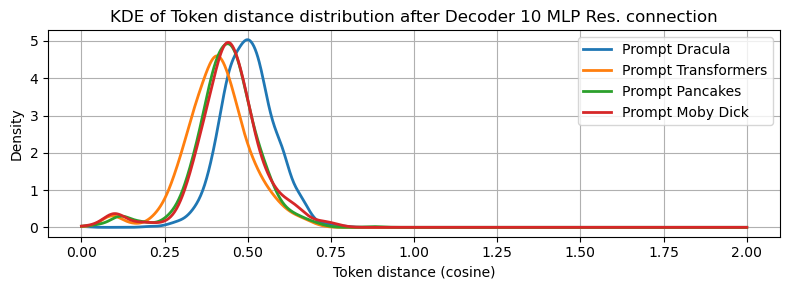

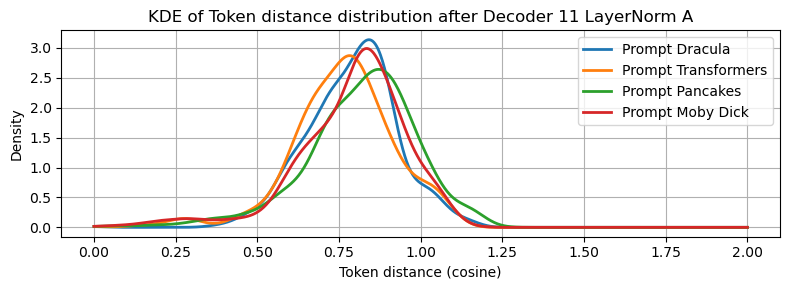

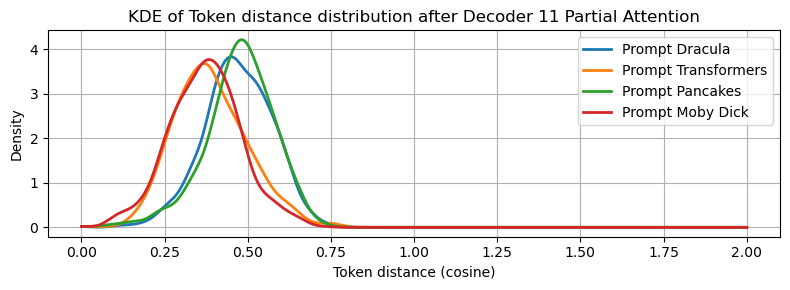

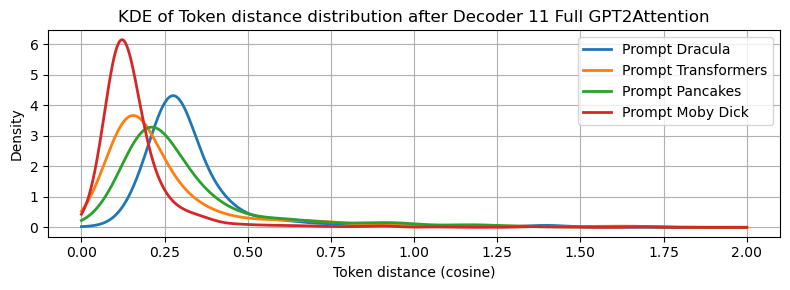

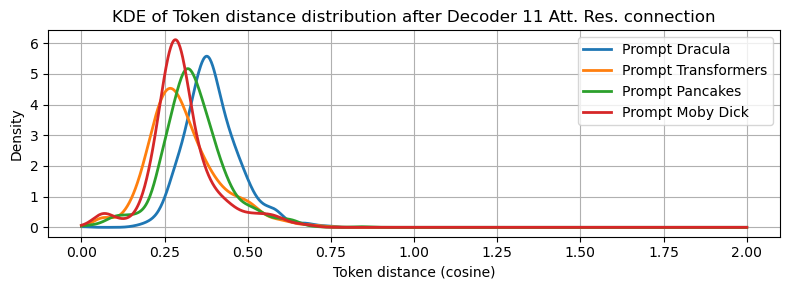

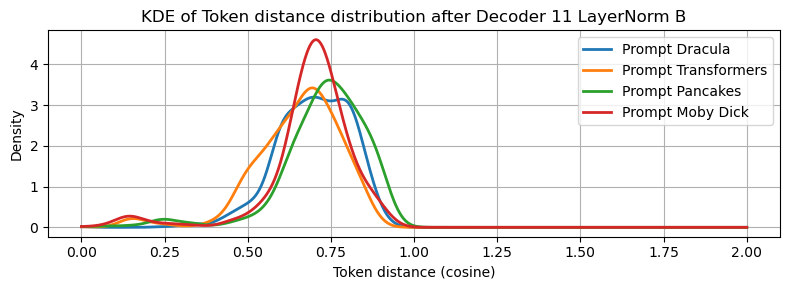

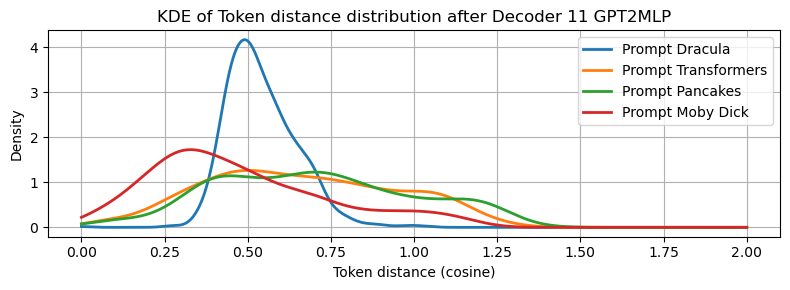

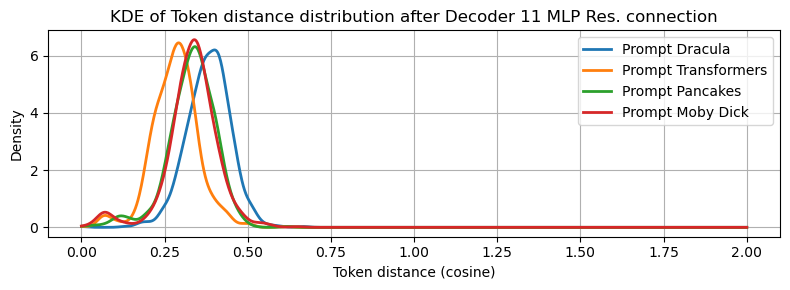

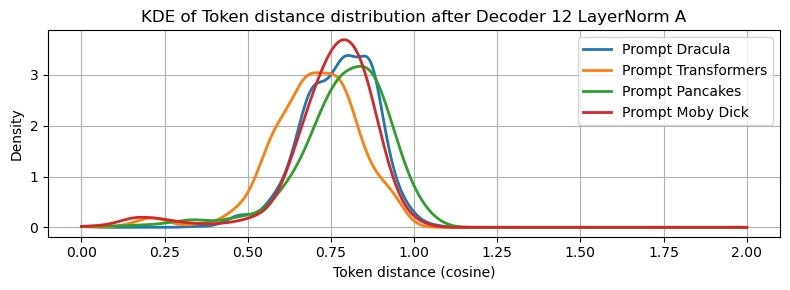

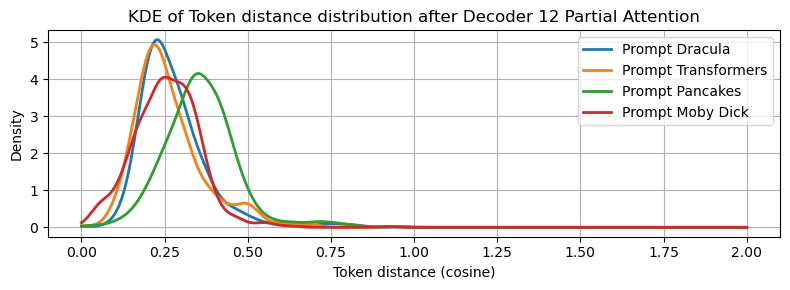

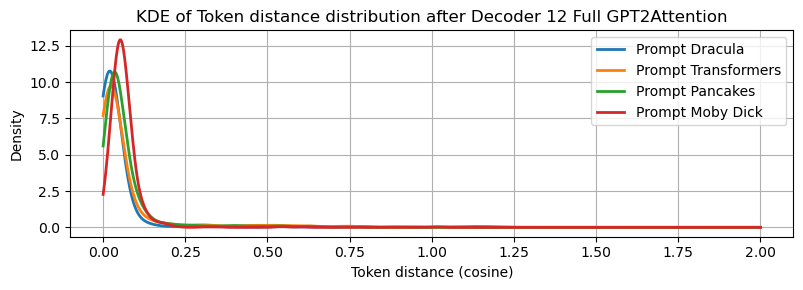

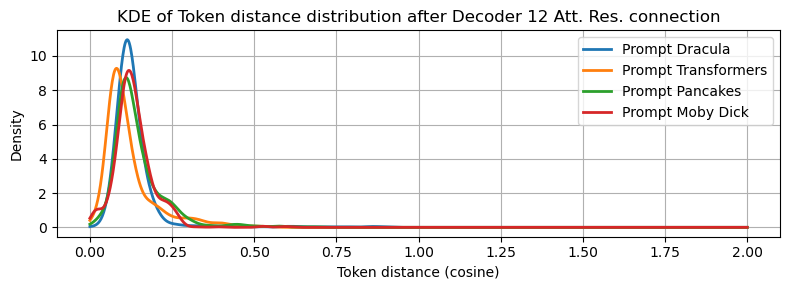

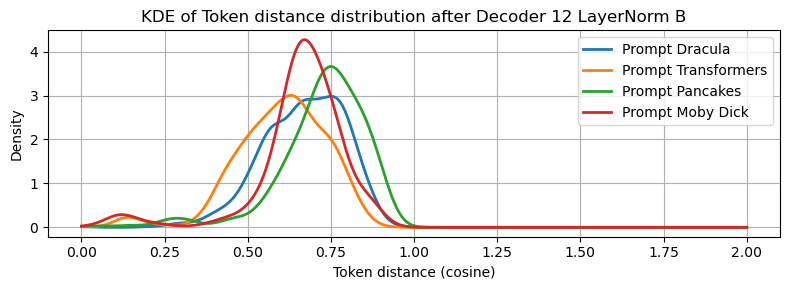

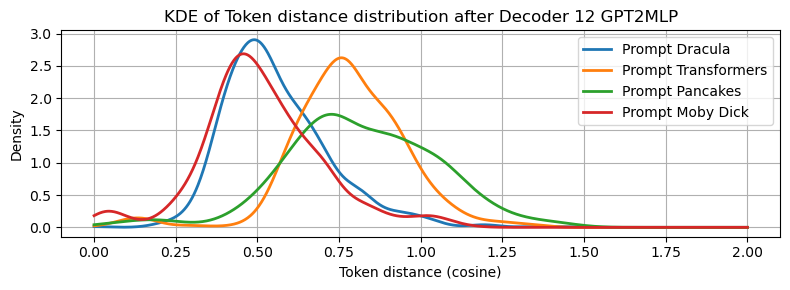

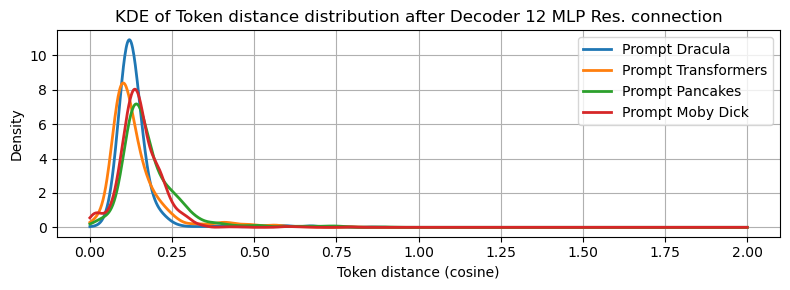

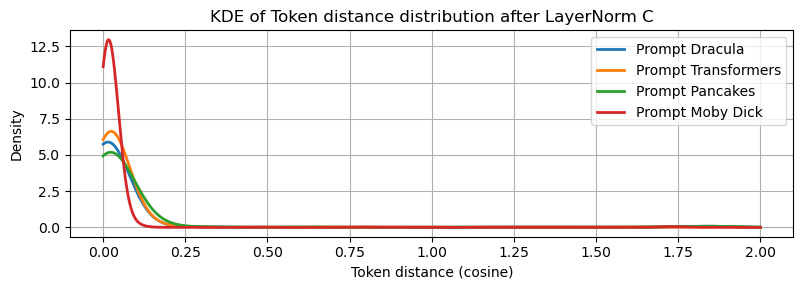

In [8]:
# Extract dist_from_token from the dictionary
dist_from_token = [dist[0] for dist in distances.values()]

# Use the idx and test_mods from one of the distances (assuming they are consistent)
module_names = distances["Dracula"][0]

# create module descriptors for plot titles
decoder_points = ["LayerNorm A", "Partial Attention", "Full GPT2Attention", "Att. Res. connection", "LayerNorm B", "GPT2MLP", "MLP Res. connection"]
decoder_labels = [f"Decoder {n} {x}" for n in range(1, 13) for x in decoder_points]
#decoder_labels = [f"Decoder {n}{x}" for n in range(1, 13) for x in string.ascii_lowercase[:7]] # for shorter labelling 1a, 1b, ..
mod_descr = ["Token Embedding", "Pos. Embedding", "Full Embedding"] + decoder_labels + ["LayerNorm C"]

# Plot KDEs
plot_labels = [f"Prompt {k}" for k in prompts.keys()]
DF.plot_kde(dist_from_token, mod_descr, plot_labels, filename="dist_kde")